In [ ]:
import os
import numpy as np
import paddle
import random
import string
from utils import Utils
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 设置设备
# DEVICE = 'gpu' if paddle.is_compiled_with_cuda() else 'cpu'
DEVICE = 'cpu'
paddle.set_device(DEVICE)

num_training_samples = 10 * 16384
num_test_samples = 128
grid_size = 8
n_test, n_train = 32, 8
checkpoint_dir = './training_dir'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

lr_ = 1.2e-5

# 功能概述
该函数用于在多网格方法中评估插值算子（P_stencil）的性能。它基于局部傅里叶分析（Local Fourier Analysis, LFA），通过构建迭代矩阵并计算其谱半径来衡量插值算子的效果。此损失函数可同时用于训练和测试阶段。

# 核心逻辑流程
## 1. 共轭处理输入矩阵
对 A_matrices 和 S_matrices 进行共轭操作，确保复数一致性。
## 2. 角度列表 theta_x 构造
生成用于 LFA 分析的角度列表 theta_x，覆盖完整的频域范围。
## 3. 测试阶段特殊处理（epoch == 0）
在第0个 epoch 测试时，使用固定方式生成 P_stencil。
计算对应的 P_matrix 及其转置共轭 P_matrix_t。
构建粗化后的系统矩阵 A_c。
移除可能导致奇异矩阵的特定频率点。
使用 scipy.linalg.solve 解决 paddle.complex128 不支持的问题。
构建迭代矩阵 CGC_removed 并计算测试损失 loss_test。
## 4. 训练或非初始测试阶段处理
根据是否有 index 决定是否传入位置信息进行模型前向传播。
重新构建 P_matrix、A_c 等结构。
同样移除特定频率点，避免矩阵奇异。
解决复杂类型问题后构造迭代矩阵 iteration_matrix_all。
根据 remove 参数选择不同的损失函数：
若启用 remove=True：使用最大值聚合策略，强调最坏情况下的收敛性；
若禁用 remove=False：使用均值损失函数，并打印实际损失。
# 返回值说明
loss_val: paddle.Tensor 类型，用于反向传播优化的损失值。
real_loss: numpy 数组类型，用于日志记录和可视化展示的实际损失值。

In [5]:
def loss(model, n, A_stencil, A_matrices, S_matrices, index=None, pos=-1., phase="Training", epoch=-1, grid_size=8, remove=True):
    A_matrices = paddle.conj(A_matrices)
    S_matrices = paddle.conj(S_matrices)
    pi = np.pi
    theta_x = np.array(([i * 2 * pi / n for i in range(-n // (grid_size * 2) + 1, n // (grid_size * 2) + 1)]))
    if phase == "Test" and epoch == 0:
        P_stencil = model(A_stencil, True)
        P_matrix = utils.compute_p2LFA(P_stencil, n, grid_size)
        P_matrix = paddle.transpose(P_matrix, [2, 0, 1, 3, 4])
        P_matrix_t = paddle.transpose(P_matrix, [0, 1, 2, 4, 3]).conj()
        A_c = paddle.matmul(paddle.matmul(P_matrix_t, A_matrices), P_matrix)

        index_to_remove = len(theta_x) * (-1 + n // (2 * grid_size)) + n // (2 * grid_size) - 1
        A_c = paddle.reshape(A_c, (-1, int(theta_x.shape[0]) ** 2, (grid_size // 2) ** 2, (grid_size // 2) ** 2))
        A_c_removed = paddle.concat([A_c[:, :index_to_remove], A_c[:, index_to_remove + 1:]], 1)
        P_matrix_t_reshape = paddle.reshape(P_matrix_t, (-1, int(theta_x.shape[0]) ** 2, (grid_size // 2) ** 2, grid_size ** 2))
        P_matrix_reshape = paddle.reshape(P_matrix, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, (grid_size // 2) ** 2))
        A_matrices_reshaped = paddle.reshape(A_matrices, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, grid_size ** 2))
        A_matrices_removed = paddle.concat([A_matrices_reshaped[:, :index_to_remove], A_matrices_reshaped[:, index_to_remove + 1:]], 1)
        P_matrix_removed = paddle.concat([P_matrix_reshape[:, :index_to_remove], P_matrix_reshape[:, index_to_remove + 1:]], 1)
        P_matrix_t_removed = paddle.concat([P_matrix_t_reshape[:, :index_to_remove], P_matrix_t_reshape[:, index_to_remove + 1:]], 1)
        # 修复complex128不支持
        if A_c_removed.dtype in [paddle.complex64, paddle.complex128]:
            import scipy.linalg
            A_c_removed_np = A_c_removed.numpy()
            P_matrix_t_removed_np = P_matrix_t_removed.numpy()
            # A_c_removed_np: [batch, num_blocks, N, N], P_matrix_t_removed_np: [batch, num_blocks, N, M]
            A_coarse_inv_removed_np = np.stack([
                np.stack([
                    scipy.linalg.solve(A_c_removed_np[i, j], P_matrix_t_removed_np[i, j])
                    for j in range(A_c_removed_np.shape[1])
                ], axis=0)
                for i in range(A_c_removed_np.shape[0])
            ], axis=0)
            A_coarse_inv_removed = paddle.to_tensor(A_coarse_inv_removed_np)
        else:
            A_coarse_inv_removed = paddle.linalg.solve(A_c_removed, P_matrix_t_removed)
        eye_mat = paddle.eye(grid_size ** 2, dtype='float64')
        eye_mat = paddle.cast(eye_mat, 'complex128')
        CGC_removed = eye_mat - paddle.matmul(paddle.matmul(P_matrix_removed, A_coarse_inv_removed), A_matrices_removed)
        S_matrices_reshaped = paddle.reshape(S_matrices, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, grid_size ** 2))
        S_removed = paddle.concat([S_matrices_reshaped[:, :index_to_remove], S_matrices_reshaped[:, index_to_remove + 1:]], 1)
        iteration_matrix = paddle.matmul(paddle.matmul(CGC_removed, S_removed), S_removed)
        loss_test = paddle.mean(paddle.mean(paddle.sum(paddle.square(paddle.abs(iteration_matrix)), axis=[2, 3]), axis=1))
        return paddle.to_tensor([0.]), loss_test.numpy()
    if index is not None:
        P_stencil = model(A_stencil, index=index, pos=pos, phase=phase)
    else:
        P_stencil = model(A_stencil, phase=phase)
    if not (phase == "Test" and epoch == 0):
        P_matrix = utils.compute_p2LFA(P_stencil, n, grid_size)
        P_matrix = paddle.transpose(P_matrix, [2, 0, 1, 3, 4])
        P_matrix_t = paddle.transpose(P_matrix, [0, 1, 2, 4, 3]).conj()
        A_c = paddle.matmul(paddle.matmul(P_matrix_t, A_matrices), P_matrix)
        index_to_remove = len(theta_x) * (-1 + n // (2 * grid_size)) + n // (2 * grid_size) - 1
        A_c = paddle.reshape(A_c, (-1, int(theta_x.shape[0]) ** 2, (grid_size // 2) ** 2, (grid_size // 2) ** 2))
        A_c_removed = paddle.concat([A_c[:, :index_to_remove], A_c[:, index_to_remove + 1:]], 1)
        P_matrix_t_reshape = paddle.reshape(P_matrix_t, (-1, int(theta_x.shape[0]) ** 2, (grid_size // 2) ** 2, grid_size ** 2))
        P_matrix_reshape = paddle.reshape(P_matrix, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, (grid_size // 2) ** 2))
        A_matrices_reshaped = paddle.reshape(A_matrices, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, grid_size ** 2))
        A_matrices_removed = paddle.concat([A_matrices_reshaped[:, :index_to_remove], A_matrices_reshaped[:, index_to_remove + 1:]], 1)
        P_matrix_removed = paddle.concat([P_matrix_reshape[:, :index_to_remove], P_matrix_reshape[:, index_to_remove + 1:]], 1)
        P_matrix_t_removed = paddle.concat([P_matrix_t_reshape[:, :index_to_remove], P_matrix_t_reshape[:, index_to_remove + 1:]], 1)
        # 修复complex128不支持
        if A_c_removed.dtype in [paddle.complex64, paddle.complex128]:
            import scipy.linalg
            A_c_removed_np = A_c_removed.numpy()
            P_matrix_t_removed_np = P_matrix_t_removed.numpy()
            # A_c_removed_np: [batch, num_blocks, N, N], P_matrix_t_removed_np: [batch, num_blocks, N, M]
            A_coarse_inv_removed_np = np.stack([
                np.stack([
                    scipy.linalg.solve(A_c_removed_np[i, j], P_matrix_t_removed_np[i, j])
                    for j in range(A_c_removed_np.shape[1])
                ], axis=0)
                for i in range(A_c_removed_np.shape[0])
            ], axis=0)
            A_coarse_inv_removed = paddle.to_tensor(A_coarse_inv_removed_np)
        else:
            A_coarse_inv_removed = paddle.linalg.solve(A_c_removed, P_matrix_t_removed)
        eye_mat = paddle.eye(grid_size ** 2, dtype='float64')
        eye_mat = paddle.cast(eye_mat, 'complex128')
        CGC_removed = eye_mat - paddle.matmul(paddle.matmul(P_matrix_removed, A_coarse_inv_removed), A_matrices_removed)
        S_matrices_reshaped = paddle.reshape(S_matrices, (-1, int(theta_x.shape[0]) ** 2, grid_size ** 2, grid_size ** 2))
        S_removed = paddle.concat([S_matrices_reshaped[:, :index_to_remove], S_matrices_reshaped[:, index_to_remove + 1:]], 1)
        iteration_matrix_all = paddle.matmul(paddle.matmul(CGC_removed, S_removed), S_removed)
        if remove:
            if phase != 'Test':
                iteration_matrix = iteration_matrix_all
                for _ in range(0):
                    iteration_matrix = paddle.matmul(iteration_matrix_all, iteration_matrix_all)
            else:
                iteration_matrix = iteration_matrix_all
            loss_val = paddle.mean(paddle.max(paddle.pow(paddle.sum(paddle.square(paddle.abs(iteration_matrix)), axis=[2, 3]), 1), axis=1))
        else:
            loss_val = paddle.mean(paddle.mean(paddle.sum(paddle.square(paddle.abs(iteration_matrix_all)), axis=[2, 3]), axis=1))
            print("Real loss: ", loss_val.numpy())
        real_loss = loss_val.numpy()
        return loss_val, real_loss


In [6]:
def grad(model, n, A_stencil, A_matrices, S_matrices, phase="Training", epoch=-1, grid_size=8, remove=True):
    with paddle.amp.auto_cast():
        loss_value, real_loss = loss(model, n, A_stencil, A_matrices, S_matrices, phase=phase, epoch=epoch, grid_size=grid_size, remove=remove)
    loss_value.backward()
    grads = [p.grad for p in model.parameters()]
    return grads, real_loss

本训练流程旨在通过局部傅里叶分析（LFA）驱动的方法，训练一个神经网络模型以学习多网格方法中的插值算子。该模型在不同尺度的网格上进行优化，并结合测试阶段的性能评估与动态生成的训练数据，逐步提升其泛化能力。

# 配置参数说明
## 基础设置
verbose ：控制是否输出详细日志信息。
use_gpu ：决定是否使用 GPU 进行加速计算。
grid_size ：定义基础网格大小，通常为 8。
batch_size ：每次训练时使用的样本数量。
bc（边界条件） ：当前支持周期性边界条件（periodic）或 Dirichlet 边界条件。
n_epochs ：每个训练数据集上的迭代轮次。
# 工具初始化
使用 Utils 类封装了所有辅助功能，包括：

A_stencil 的生成；
A_matrix 和 S_matrix 的构建；
LFA 分析相关操作；
多尺度训练数据的构造。

# 模型选择与优化器配置
根据所选边界条件，从不同的模块中导入相应的插值网络架构：

model_periodicBC.Pnetwork：适用于周期性边界；
model_dirichletBC.Pnetwork：适用于 Dirichlet 边界。
使用 Adam 优化器对模型参数进行更新。

# 数据准备
## 测试数据
从工具类中加载预定义的测试用 stencil 及对应的矩阵集合（A 和 S），并将其转换为 PaddlePaddle 张量格式。

## 训练数据
初始训练数据由二维 stencil 构造函数生成。后续训练阶段将加入由当前模型生成的粗粒度样本，构成一种渐进式训练策略。

# 主训练循环逻辑
主循环按 n_train_list 中指定的不同网格尺寸依次进行训练，每一轮包括多个 epoch。

每个 epoch 的处理步骤
## 测试评估 ：
在测试集上运行模型以评估当前性能；
## 模型保存 ：
按固定间隔保存模型参数和优化器状态；
## 批处理训练 ：
对训练数据进行随机采样；
动态生成当前批次的 A 矩阵和 S 矩阵；
使用 grad 函数计算损失并更新模型参数；
## 日志记录（可选） ：
若启用 TensorBoard，可记录训练过程中的损失变化。
# 多尺度训练策略
在训练过程中引入“多层级”训练机制：

后续训练阶段使用更粗的网格尺寸；
利用当前模型生成额外的训练样本；
提升模型在不同尺度下的适应能力和鲁棒性。
这种机制模拟了多网格方法中的层次结构，使得模型能够更好地逼近最优插值算子。

In [7]:
verbose = False
use_gpu = False
grid_size = 8
batch_size = 32
bc = 'periodic'
n_epochs=2

paddle.set_device(DEVICE)
# if use_gpu:
#     paddle.set_device('gpu')
# else:
#     paddle.set_device('cpu')

utils = Utils(grid_size=grid_size, device=DEVICE, bc=bc)

random_string = ''.join(random.choices(string.digits, k=5))  # to make the run_name string unique
run_name = f"regularization_grid_size={grid_size}_batch_size={batch_size}_{random_string}"
# writer = SummaryWriter(log_dir='runs/' + run_name)

if bc == 'periodic':
    from model_periodicBC import Pnetwork
else:
    from model_dirichletBC import Pnetwork

m = Pnetwork(grid_size=grid_size)
optimizer = paddle.optimizer.Adam(parameters=m.parameters(), learning_rate=lr_)

pi = np.pi
ci = 1j

A_stencils_test, A_matrices_test, S_matrices_test, num_of_modes = utils.get_A_S_matrices(num_test_samples, np.pi, grid_size, n_test)
A_stencils_test = paddle.to_tensor(A_stencils_test, dtype='float64')
A_matrices_test = paddle.to_tensor(A_matrices_test, dtype='complex128')
S_matrices_test = paddle.reshape(paddle.to_tensor(S_matrices_test, dtype='complex128'), (-1, num_of_modes, num_of_modes, grid_size ** 2, grid_size ** 2))

A_stencils_train = np.array(utils.two_d_stencil(num_training_samples))
n_train_list = [16, 16, 32]
initial_epsi = 1e-0

numiter = -1
for j in range(len(n_train_list)):
    A_stencils = A_stencils_train.copy()
    n_train = n_train_list[j]

    theta_x = np.array([i * 2 * pi / n_train for i in range(-n_train // (2 * grid_size) + 1, n_train // (2 * grid_size) + 1)])
    theta_y = np.array([i * 2 * pi / n_train for i in range(-n_train // (2 * grid_size) + 1, n_train // (2 * grid_size) + 1)])

    for epoch in range(n_epochs):
        print("epoch: {}".format(epoch))
        order = np.random.permutation(num_training_samples)

        _, blackbox_test_loss = grad(model=m, n=n_test, A_stencil=A_stencils_test, A_matrices=A_matrices_test, S_matrices=S_matrices_test, phase="Test", epoch=0, grid_size=grid_size)

        if epoch % 1 == 0:  # change to save once every X epochs
            paddle.save(m.state_dict(), checkpoint_prefix + f"_model_epoch{epoch}.pdparams")
            paddle.save(optimizer.state_dict(), checkpoint_prefix + f"_optim_epoch{epoch}.pdopt")

        for iter in tqdm(range(num_training_samples // batch_size)):
            numiter += 1
            idx = np.random.choice(A_stencils.shape[0], batch_size, replace=False)
            A_matrices = np.stack([[utils.compute_A(A_stencils[idx], tx, ty, 1j, grid_size=grid_size) for tx in theta_x] for ty in theta_y])
            A_matrices = A_matrices.transpose((2, 0, 1, 3, 4))
            S_matrices = np.reshape(utils.compute_S(A_matrices.reshape((-1, grid_size ** 2, grid_size ** 2))), (-1, theta_x.shape[0], theta_x.shape[0], grid_size ** 2, grid_size ** 2))
            A_stencils_tensor = paddle.to_tensor(A_stencils[idx], dtype='float64')
            A_matrices_tensor = paddle.to_tensor(A_matrices, dtype='complex128')
            S_matrices_tensor = paddle.to_tensor(S_matrices, dtype='complex128')
            _, blackbox_train_loss = grad(m, n_train, A_stencils_tensor, A_matrices_tensor, S_matrices_tensor, epoch=0, grid_size=grid_size, remove=True, phase="Test")
            grads, real_loss = grad(m, n_train, A_stencils_tensor, A_matrices_tensor, S_matrices_tensor, grid_size=grid_size, remove=True, phase="p")
            optimizer.step()
            optimizer.clear_grad()
            # writer.add_scalar('loss', real_loss, numiter)
            # writer.add_scalar('blackbox_train_loss', blackbox_train_loss, numiter)
            # writer.add_scalar('blackbox_test_loss', blackbox_test_loss, numiter)

    # add coarse grid problems:
    if j > 0:
        num_training_sampleps = num_training_samples // 2
    temp = utils.create_coarse_training_set(m, pi, num_training_samples)
    A_stencils_train = np.concatenate([np.array(utils.two_d_stencil(num_training_samples)), temp], axis=0)
    num_training_samples = A_stencils_train.shape[0]

epoch: 0


100%|██████████| 5120/5120 [43:26<00:00,  1.96it/s]  


epoch: 1


100%|██████████| 1280/1280 [12:21<00:00,  1.73it/s]


epoch: 0


100%|██████████| 10240/10240 [1:26:33<00:00,  1.97it/s] 


epoch: 1


100%|██████████| 1280/1280 [12:27<00:00,  1.71it/s]


epoch: 0


100%|██████████| 10240/10240 [3:37:19<00:00,  1.27s/it] 


epoch: 1


100%|██████████| 1280/1280 [12:25<00:00,  1.72it/s]


In [8]:
paddle.save(m.state_dict(), checkpoint_prefix + f"_model_epoch{epoch}_final.pdparams")
paddle.save(optimizer.state_dict(), checkpoint_prefix + f"_optim_epoch{epoch}_final.pdopt")

In [ ]:
import matplotlib.pyplot as plt
import scipy

grid_size = 255
num_test_samples = 100
boundary = 'dirichlet'
compute_spectral_radius = False
bb_row_normalize = False

num_cycles = 41
utils = Utils(grid_size=grid_size, device=DEVICE, bc=boundary)
if boundary == 'dirichlet':
    from model_dirichletBC import Pnetwork
else:
    from model_periodicBC import Pnetwork
m = Pnetwork(grid_size=grid_size)

checkpoint_dir = './training_dir'
# 加载模型参数
import glob
model_files = sorted(glob.glob(checkpoint_dir + '/*.pdparams'))
# if model_files:
#     m.set_state_dict(paddle.load(model_files[-1]))
m.set_state_dict(paddle.load(checkpoint_dir + '/ckpt_model_epoch1_final.pdparams'))
m.eval()


# 数据准备
从工具类中生成一组用于测试的二维 stencil 样本，每个样本代表一个离散化的微分算子。这些 stencil 将被转换为稀疏矩阵形式，用于构造对应的线性系统。

# 模型评估循环
对每一个测试 stencil，执行以下步骤：

# 黑盒多网格求解
使用默认的插值/限制策略进行多网格迭代；
记录每次迭代的残差与误差；
可选：计算迭代矩阵的 Frobenius 范数与谱半径；
存储结果以供后续分析。
# 基于网络的插值求解
使用训练好的神经网络模型生成插值矩阵；
构建对应的多网格求解器；
执行 W-cycle 多网格迭代；
同样记录残差、误差，并可选地分析迭代矩阵的谱性质；
存储结果用于对比。

In [12]:
print('running test')
black_box_residual_norms = []
black_box_errors = []
black_box_frob_norms = []
black_box_spectral_radii = []
net_residual_norms = []
net_errors = []
network_spectral_radii = []
network_frob_norms = []
A_stencils_test = utils.two_d_stencil(num=num_test_samples, grid_size=grid_size, epsilon=0.0)
for A_stencil in tqdm(A_stencils_test):
    A_matrix = utils.compute_csr_matrices(stencils=A_stencil, grid_size=grid_size)

    A_stencil_pd = paddle.to_tensor([A_stencil], dtype='float64')
    b = np.zeros(shape=(grid_size ** 2, 1))

    initial = np.random.normal(loc=0.0, scale=1.0, size=grid_size ** 2)
    initial = initial[:, np.newaxis]

    _, residual_norms, error_norms, solver = utils.solve_with_model(model=m,
                                                                    A_matrices=A_matrix, b=b,
                                                                    initial_guess=initial,
                                                                    max_iterations=num_cycles,
                                                                    max_depth=int(np.log2(grid_size)) - 1,
                                                                    blackbox=True,
                                                                    w_cycle=True)
    black_box_errors.append(error_norms)
    black_box_residual_norms.append(residual_norms)
    if compute_spectral_radius:
        I = np.eye(grid_size ** 2, dtype=np.double)
        P = solver.levels[0].P
        R = solver.levels[0].R
        A = solver.levels[0].A
        C = I - P @ scipy.sparse.linalg.inv(R @ A @ P) @ R @ A

        L = scipy.sparse.tril(A)
        S = I - scipy.sparse.linalg.inv(L) @ A
        M = S @ C @ S
        black_box_frob_norms.append(scipy.linalg.norm(M))
        eigs, _ = scipy.sparse.linalg.eigs(M)
        black_box_spectral_radius = eigs.max()
        black_box_spectral_radii.append(black_box_spectral_radius)

    x, residual_norms, error_norms, solver = utils.solve_with_model(model=m,
                                                                    A_matrices=A_matrix, b=b, initial_guess=initial,
                                                                    max_iterations=num_cycles,
                                                                    max_depth=int(np.log2(grid_size)) - 1,
                                                                    blackbox=False,
                                                                    w_cycle=True)

    net_errors.append(error_norms)
    net_residual_norms.append(residual_norms)
    if compute_spectral_radius:
        I = np.eye(grid_size ** 2, dtype=np.double)
        P = solver.levels[0].P
        R = solver.levels[0].R
        A = solver.levels[0].A
        C = I - P @ scipy.sparse.linalg.inv(R @ A @ P) @ R @ A

        L = scipy.sparse.tril(A)
        S = I - scipy.sparse.linalg.inv(L) @ A
        M = S @ C @ S
        network_frob_norms.append(scipy.linalg.norm(M))
        eigs, _ = scipy.sparse.linalg.eigs(M)
        network_spectral_radius = eigs.max()
        network_spectral_radii.append(network_spectral_radius)


running test


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


结果可视化

network asymptotic error factor: 0.1518 ± 0.01407
black box asymptotic error factor: 0.1792 ± 0.01185
network success rate: 98.0%



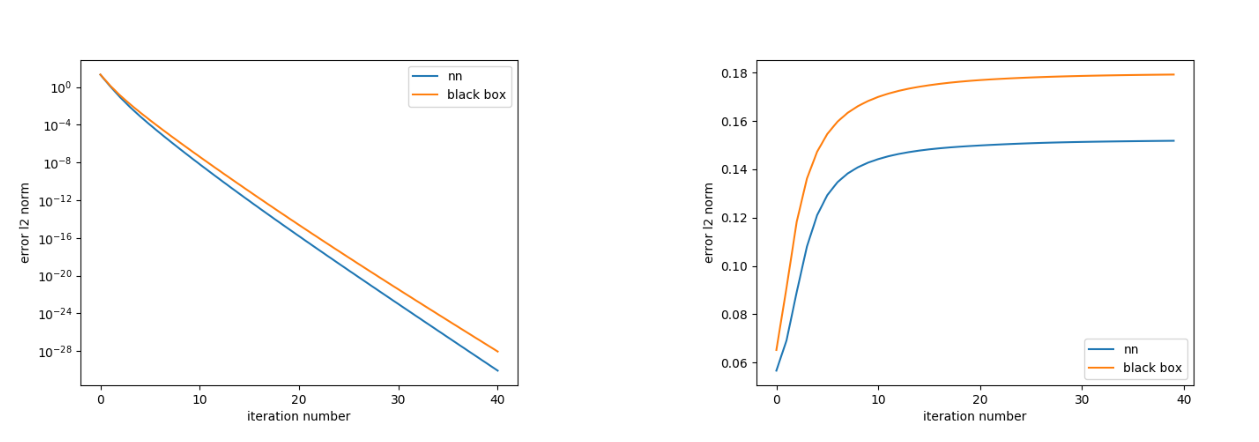

In [ ]:
net_errors = np.array(net_errors)
net_errors_log = np.log2(net_errors)
net_errors_div_diff = 2 ** np.diff(net_errors_log)
net_errors_mean = np.mean(net_errors, axis=0)
net_errors_std = np.std(net_errors, axis=0)
net_errors_div_diff_mean = np.mean(net_errors_div_diff, axis=0)
net_errors_div_diff_std = np.std(net_errors_div_diff, axis=0)

black_box_errors = np.array(black_box_errors)
black_box_errors_log = np.log2(black_box_errors)
black_box_errors_div_diff = 2 ** np.diff(black_box_errors_log)
black_box_errors_mean = np.mean(black_box_errors, axis=0)
black_box_errors_std = np.std(black_box_errors, axis=0)
black_box_errors_div_diff_mean = np.mean(black_box_errors_div_diff, axis=0)
black_box_errors_div_diff_std = np.std(black_box_errors_div_diff, axis=0)

results_file = open("results/results.txt", 'w')
print(f"network asymptotic error factor: {net_errors_div_diff_mean[-1]:.4f} ± {net_errors_div_diff_std[-1]:.5f}",
        file=results_file)
print(
    f"black box asymptotic error factor: {black_box_errors_div_diff_mean[-1]:.4f} ± {black_box_errors_div_diff_std[-1]:.5f}",
    file=results_file)
net_success_rate = sum(net_errors_div_diff[:, -1] < black_box_errors_div_diff[:, -1]) / num_test_samples
print(f"network success rate: {100 * net_success_rate}%",
        file=results_file)
if compute_spectral_radius:
    network_spectral_radii = np.array(network_spectral_radii)
    network_spectral_mean = network_spectral_radii.mean()
    network_spectral_std = network_spectral_radii.std()
    network_frob_norms = np.array(network_frob_norms)
    network_frob_mean = network_frob_norms.mean()
    network_frob_std = network_frob_norms.std()
    black_box_spectral_radii = np.array(black_box_spectral_radii)
    black_box_spectral_mean = black_box_spectral_radii.mean()
    black_box_spectral_std = black_box_spectral_radii.std()
    black_box_frob_norms = np.array(black_box_frob_norms)
    black_box_frob_mean = black_box_frob_norms.mean()
    black_box_frob_std = black_box_frob_norms.std()
    print(f"network spectral radius: {network_spectral_mean:.4f} ± {network_spectral_std:.5f}",
            file=results_file)
    print(f"network frobenius norm: {network_frob_mean:.4f} ± {network_frob_std:.5f}",
            file=results_file)
    print(f"black box spectral radius: {black_box_spectral_mean:.4f} ± {black_box_spectral_std:.5f}",
            file=results_file)
    print(f"black box frobenius norm: {black_box_frob_mean:.4f} ± {black_box_frob_std:.5f}",
            file=results_file)
results_file.close()
with open("results/results.txt", 'r') as f:
    print(f.read())

plt.figure()
plt.plot(np.arange(len(net_errors_mean), dtype=np.int), net_errors_mean, label='nn')
plt.plot(np.arange(len(black_box_errors_mean), dtype=np.int), black_box_errors_mean, label='black box')
plt.xticks(np.arange(len(black_box_errors_mean), step=10))
plt.xlabel('iteration number')
plt.ylabel('error l2 norm')
plt.yscale('log')
plt.legend()
plt.savefig('results/test_p.png')

plt.figure()
plt.plot(np.arange(len(net_errors_div_diff_mean), dtype=np.int), net_errors_div_diff_mean, label='nn')
plt.plot(np.arange(len(black_box_errors_div_diff_mean), dtype=np.int), black_box_errors_div_diff_mean,
            label='black box')
plt.xticks(np.arange(len(black_box_errors_mean), step=10))
plt.xlabel('iteration number')
plt.ylabel('error l2 norm')
plt.legend()
plt.savefig('results/test_div_diff.png')


# 图像文件路径
image_path1 = 'results/test_p.png'
image_path2 = 'results/test_div_diff.png'

# 读取图像
img1 = plt.imread(image_path1)
img2 = plt.imread(image_path2)

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 行 2 列的子图

# 显示第一幅图像
axes[0].imshow(img1)
axes[0].axis('off')  # 关闭坐标轴

# 显示第二幅图像
axes[1].imshow(img2)
axes[1].axis('off')  # 关闭坐标轴

# 显示图像
plt.show()
